In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import os
import requests


In [2]:

#reset it up using my API
alphavantage_api_key = os.getenv("ALPHAVANTAGE_API_KEY")
alphavantage_api_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey={alphavantage_api_key}"
response = requests.get(alphavantage_api_url)
if response.status_code == 200:
    data = response.json()
    print("Data fetched successfully.")
    print(data)  # Print a sample of the data
else:
    print(f"Error fetching data: {response.status_code}")
    data = None




Data fetched successfully.
{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'MSFT', '3. Last Refreshed': '2025-05-09', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-05-09': {'1. open': '440.0000', '2. high': '440.7400', '3. low': '435.8800', '4. close': '438.7300', '5. volume': '15324233'}, '2025-05-08': {'1. open': '437.9300', '2. high': '443.6700', '3. low': '435.6600', '4. close': '438.1700', '5. volume': '23491330'}, '2025-05-07': {'1. open': '433.8400', '2. high': '438.1200', '3. low': '431.1103', '4. close': '433.3500', '5. volume': '23307241'}, '2025-05-06': {'1. open': '432.2000', '2. high': '437.7300', '3. low': '431.1700', '4. close': '433.3100', '5. volume': '15104204'}, '2025-05-05': {'1. open': '432.8700', '2. high': '439.5000', '3. low': '432.1100', '4. close': '436.1700', '5. volume': '20136053'}, '2025-05-02': {'1. open': '431.7400', '2. high': '439.4400', '3. low': '429.9850

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
from copy import deepcopy as dc

def prepare_dataframe_for_GRU(data):
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df.columns = df.columns.get_level_values(0)
    df.index.name = 'Date'
    df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}, inplace=True)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.head()
    return df

df = prepare_dataframe_for_GRU(data)
print(df.head())




                Open      High       Low     Close    Volume
Date                                                        
2025-05-09  440.0000  440.7400  435.8800  438.7300  15324233
2025-05-08  437.9300  443.6700  435.6600  438.1700  23491330
2025-05-07  433.8400  438.1200  431.1103  433.3500  23307241
2025-05-06  432.2000  437.7300  431.1700  433.3100  15104204
2025-05-05  432.8700  439.5000  432.1100  436.1700  20136053


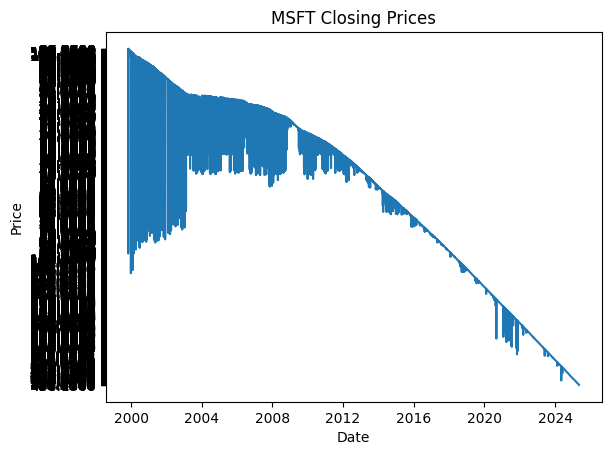

In [5]:
plt.plot(df['Close'])
plt.title('MSFT Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Open', 'Volume', 'Low', 'High']])

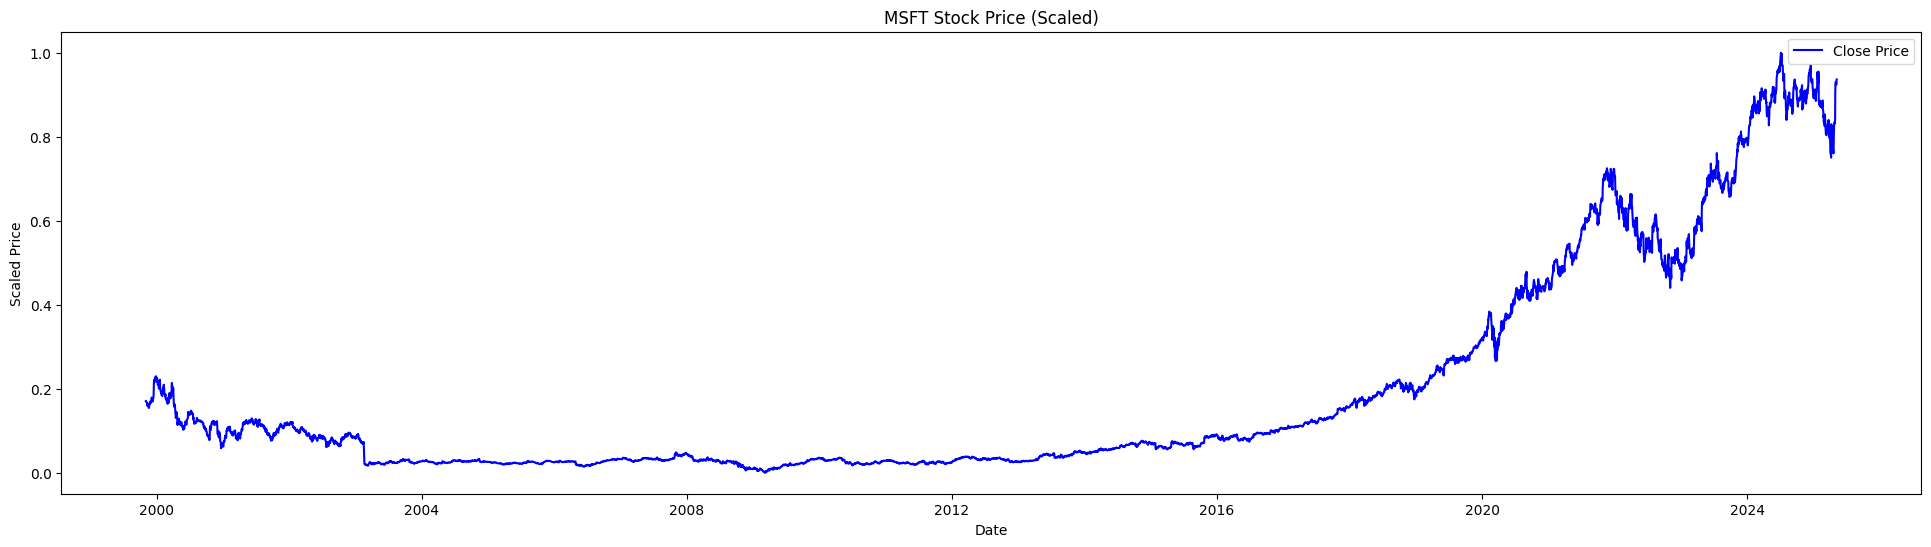

In [7]:
plt.figure(figsize=(24, 6))
plt.plot(df.index, scaled_data[:, 0], label='Close Price', color='blue')
plt.title('MSFT Stock Price (Scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()

plt.show()


In [8]:
def create_sliding_window(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sliding_window(scaled_data, window_size)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
print(f"X shape after reshaping: {X.shape}")

X shape: (6390, 30, 5), y shape: (6390,)
X shape after reshaping: (6390, 30, 5)


In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 5112, Testing Samples: 1278


In [10]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out
    
model = GRUModel(input_size=5, hidden_size=64, output_size=1).to(device)
criterion = nn.MSELoss()


In [11]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)


In [12]:
epoch = 0
while epoch < num_epochs:
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor.view(-1, 1))
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    epoch += 1
    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
        # Save the model checkpoint
        torch.save(model.state_dict(), 'gru_model.pth')
        print("Model saved.")


Epoch [1/100], Loss: 0.0823
Model saved.
Epoch [2/100], Loss: 0.0737
Model saved.
Epoch [3/100], Loss: 0.0662
Model saved.
Epoch [4/100], Loss: 0.0598
Model saved.
Epoch [5/100], Loss: 0.0543
Model saved.
Epoch [6/100], Loss: 0.0496
Model saved.
Epoch [7/100], Loss: 0.0457
Model saved.
Epoch [8/100], Loss: 0.0422
Model saved.
Epoch [9/100], Loss: 0.0390
Model saved.
Epoch [10/100], Loss: 0.0360
Model saved.
Epoch [11/100], Loss: 0.0330
Model saved.
Epoch [12/100], Loss: 0.0300
Model saved.
Epoch [13/100], Loss: 0.0270
Model saved.
Epoch [14/100], Loss: 0.0240
Model saved.
Epoch [15/100], Loss: 0.0210
Model saved.
Epoch [16/100], Loss: 0.0181
Model saved.
Epoch [17/100], Loss: 0.0152
Model saved.
Epoch [18/100], Loss: 0.0125
Model saved.
Epoch [19/100], Loss: 0.0100
Model saved.
Epoch [20/100], Loss: 0.0077
Model saved.
Epoch [21/100], Loss: 0.0056
Model saved.
Epoch [22/100], Loss: 0.0038
Model saved.
Epoch [23/100], Loss: 0.0023
Model saved.
Epoch [24/100], Loss: 0.0012
Model saved.
E

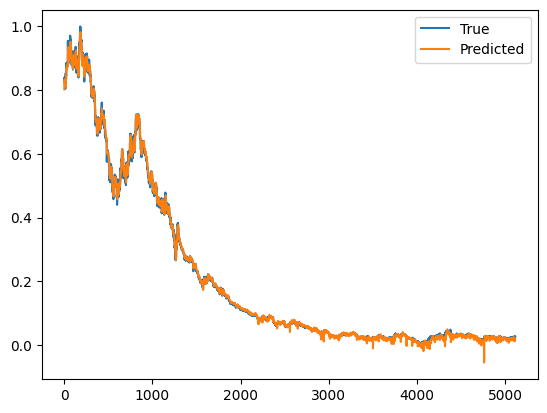

In [13]:
with torch.no_grad():
    predicted = model(X_train_tensor).to('cpu').numpy()

plt.plot(y_train, label='True')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()


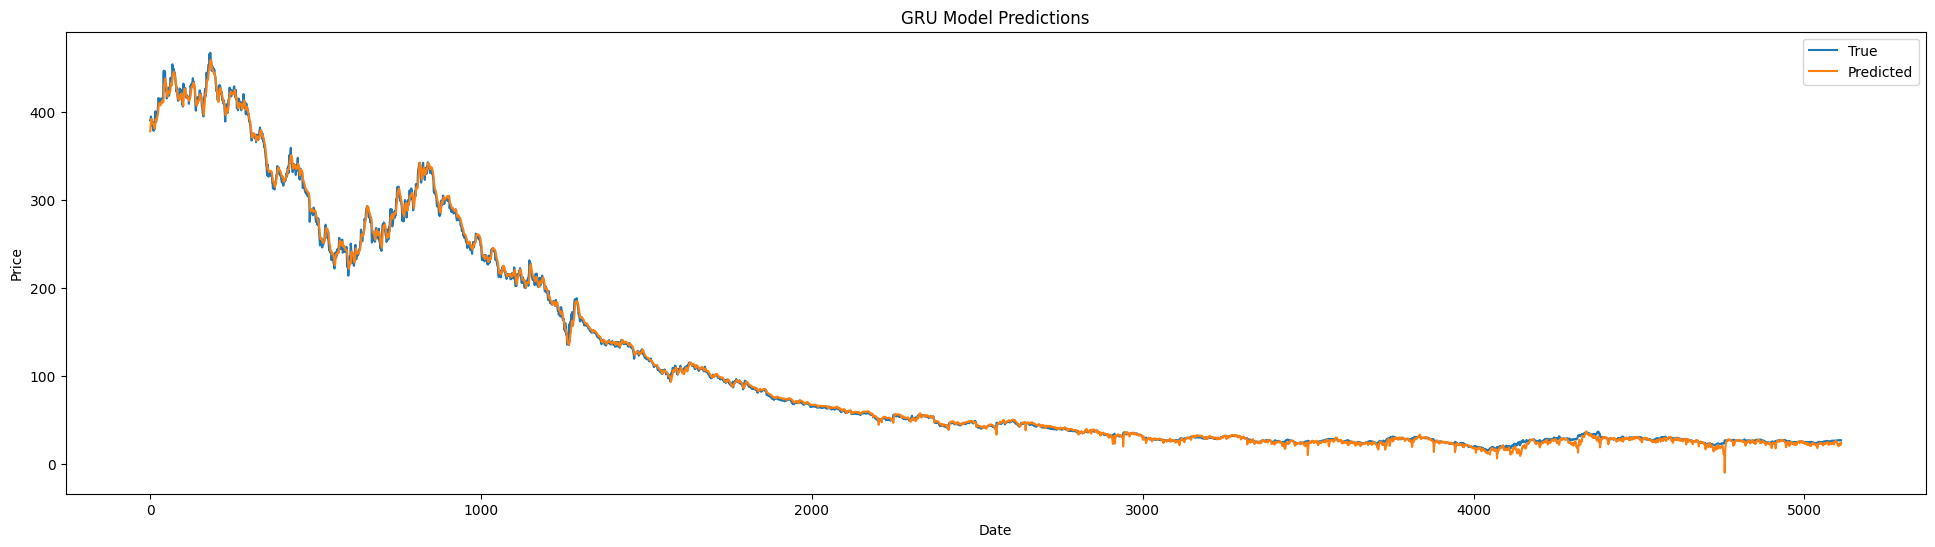

In [14]:
#unscale the predicted values
predicted = scaler.inverse_transform(np.concatenate((predicted, np.zeros((predicted.shape[0], 4))), axis=1))[:, 0]
y_train_unscaled = scaler.inverse_transform(np.concatenate((y_train_tensor.view(-1, 1).cpu().numpy(), np.zeros((y_train_tensor.shape[0], 4))), axis=1))[:, 0]
plt.figure(figsize=(24, 6))
plt.plot(y_train_unscaled, label='True')
plt.plot(predicted, label='Predicted')
plt.title('GRU Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Test Accuracy: 95.78%


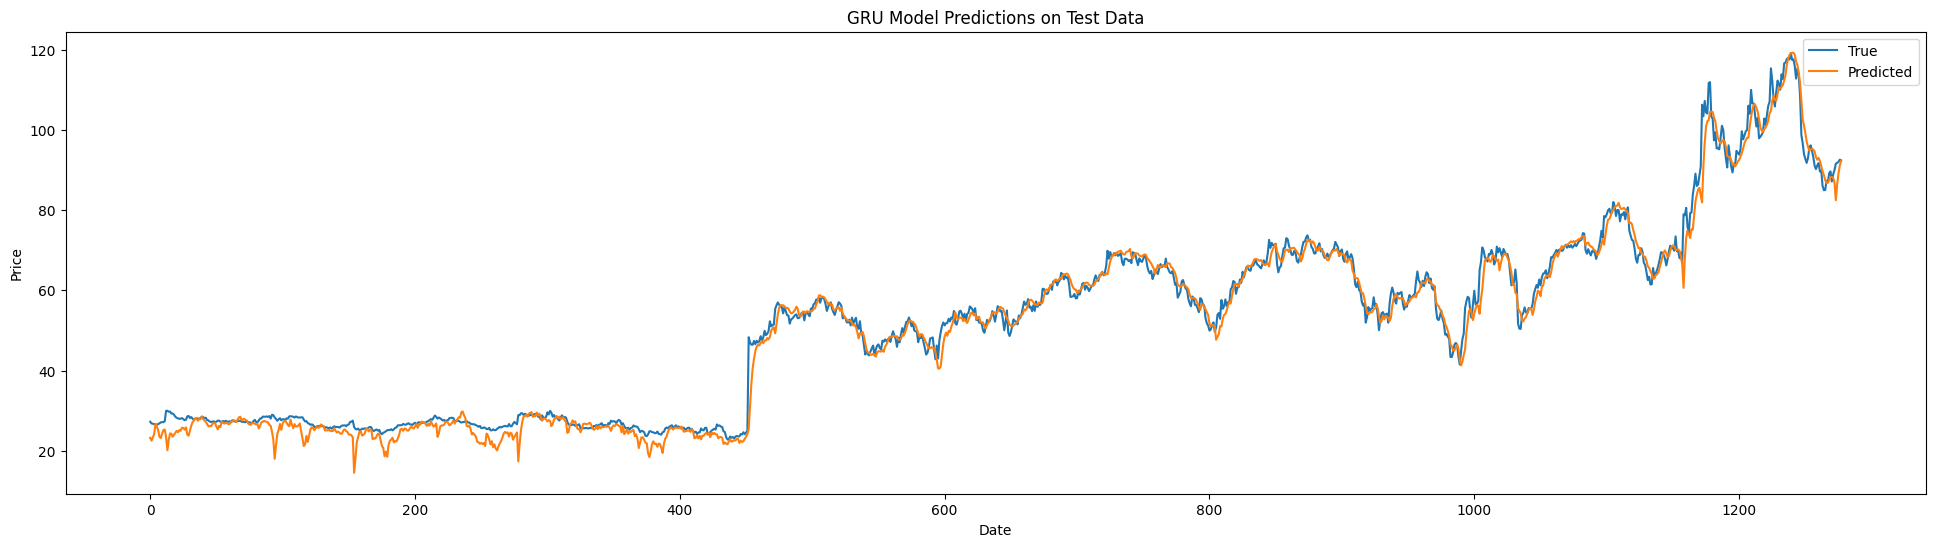

In [15]:
#Test the model calculate accuracy
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
with torch.no_grad():
    predicted_test = model(X_test_tensor).to('cpu').numpy()
predicted_test = scaler.inverse_transform(np.concatenate((predicted_test, np.zeros((predicted_test.shape[0], 4))), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test_tensor.view(-1, 1).cpu().numpy(), np.zeros((y_test_tensor.shape[0], 4))), axis=1))[:, 0]
accuracy = np.mean(np.abs((y_test_unscaled - predicted_test) / y_test_unscaled)) * 100
print(f"Test Accuracy: {100 - accuracy:.2f}%")

plt.figure(figsize=(24, 6))
plt.plot(y_test_unscaled, label='True')
plt.plot(predicted_test, label='Predicted')
plt.title('GRU Model Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()